In [1]:
import  os                              as os
import  cv2                             as cv2
import  numpy                           as np
import  pandas                          as pd
import  matplotlib.pyplot               as plt

from    sklearn.metrics                 import ConfusionMatrixDisplay
from    sklearn.mixture                 import GaussianMixture
from    sklearn.decomposition           import PCA
from    sklearn.discriminant_analysis   import LinearDiscriminantAnalysis
from    sklearn.model_selection         import cross_val_score
from    sklearn.model_selection         import KFold
from    matplotlib.colors               import ListedColormap
from    matplotlib.patches              import Ellipse

<center><font color="#e30b5d"><h1>Question 5</h1></font></center>
<center><font color="#00FF00"><h2>Part A</h2></font></center>

In [4]:
def loadImages(dirName):
    data  = []
    label = []
    for root, dirs, files in os.walk(dirName):
        for file in files:
            face = plt.imread(os.path.join(root, file))
            face = face.reshape(256 * 256, ).tolist()
            data.append(face)
            label.append(file.split('.')[1])
    return np.asarray(data) , label

In [5]:
train_data , train_label = loadImages('train')
test_data , test_label   = loadImages('test')

print("number of train data images is" , train_data.shape[0] , "and number of features for each image is", train_data.shape[1])

number of train data images is 154 and number of features for each image is 65536


In [6]:
%%capture
pca = PCA()
pca.fit(train_data)

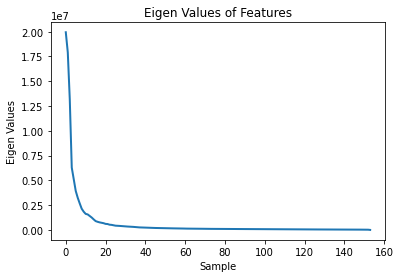

In [7]:
eigenvalues = pca.explained_variance_

plt.plot(np.arange(len(eigenvalues)), eigenvalues, linewidth = 2)
plt.title('Eigen Values of Features')
plt.xlabel('Sample')
plt.ylabel('Eigen Values')
plt.show()

In [8]:
eigenvector = pca.components_

In [9]:
eigenvalues[:4].astype(int)

array([19942410, 17914136, 13182893,  6288197])

In [10]:
eigenvalues[-4:].astype(int)

array([26264, 25822, 21384,     0])

In [11]:
eigenvalues[:4].astype(float)/eigenvalues[-4:].astype(float)

array([7.59295831e+02, 6.93747680e+02, 6.16469818e+02, 9.70126352e+29])

<center><font color="#00FF00"><h2>Part B</h2></font></center>

In [12]:
dfd                 = pd.read_csv('trainData.csv').to_numpy()
dft                 = pd.read_csv('trainLabels.csv').to_numpy()

In [13]:
lda                 = LinearDiscriminantAnalysis()
lda.fit(dfd, dft)

# Get the class means
class_means         = lda.means_

# Get the within-class scatter matrix
Sw = np.zeros((dfd.shape[1], dfd.shape[1]))  # Initialize Sw as a zero matrix

for i in range(lda.classes_.size):
    class_indices   = np.where(dft == lda.classes_[i])  # Get indices of samples in the current class
    class_X         = dfd[class_indices]  # Get samples in the current class
    class_mean      = class_X.mean(axis=0)  # Calculate mean of the current class
    class_scatter   = np.cov(class_X.T)  # Calculate scatter matrix of the current class
    Sw              += class_scatter

# Apply regularization to Sw
Sw                  += np.eye(dfd.shape[1]) * 1e-8  # Add a small positive constant to the diagonal elements

# Get the between-class scatter matrix
overall_mean        = dfd.mean(axis=0)  # Calculate the overall mean
Sb = np.zeros((dfd.shape[1], dfd.shape[1]))  # Initialize Sb as a zero matrix

for i in range(lda.classes_.size):
    n_samples       = np.sum(dft == lda.classes_[i])  # Count the number of samples in the current class
    class_mean_diff = class_means[i] - overall_mean  # Calculate the difference between class mean and overall mean
    Sb              += n_samples * np.outer(class_mean_diff, class_mean_diff)

# Compute the scattering matrix (Sw^{-1} * Sb)
scattering_matrix   = np.linalg.inv(Sw).dot(Sb)
eigenvalues, _      = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


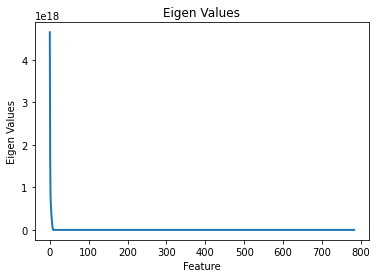

In [15]:
plt.plot(eigenvalues, linewidth = 2)
plt.xlabel('Feature')
plt.ylabel('Eigen Values')
plt.title('Eigen Values')
plt.show()

In [16]:
dfSw                 = pd.DataFrame(Sw)
dfSb                 = pd.DataFrame(Sb)

In [17]:
dfdSw_value          = dfSw.apply(lambda x : x**2).sum(axis = 0)
dfdSb_value          = dfSb.apply(lambda x : x**2).sum(axis = 0)
separability_measure = np.trace(np.linalg.inv(Sw).dot(Sb))

In [18]:
%%capture
num_feature   = dfd.shape[1]
trace_results = []

for feature_idx in range(1, 30):
    lda = LinearDiscriminantAnalysis()
    lda.fit(dfd[:, :feature_idx], dft)

    # Get the within-class scatter matrix
    Sw = np.zeros((dfd.shape[1], dfd.shape[1]))  # Initialize Sw as a zero matrix
    for i in range(lda.classes_.size):
        class_indices = np.where(dft == lda.classes_[i])  # Get indices of samples in the current class
        class_X = dfd[class_indices]  # Get samples in the current class
        class_mean = class_X.mean(axis=0)  # Calculate mean of the current class
        class_scatter = np.cov(class_X.T)  # Calculate scatter matrix of the current class
        Sw += class_scatter
    # Apply regularization to Sw
    Sw += np.eye(dfd.shape[1]) * 1e-8  # Add a small positive constant to the diagonal elements
    
    # Get the between-class scatter matrix
    overall_mean = dfd.mean(axis=0)  # Calculate the overall mean
    Sb = np.zeros((dfd.shape[1], dfd.shape[1]))  # Initialize Sb as a zero matrix

    for i in range(lda.classes_.size):
        n_samples = np.sum(dft == lda.classes_[i])  # Count the number of samples in the current class
        class_mean_diff = class_means[i] - overall_mean  # Calculate the difference between class mean and overall mean
        Sb += n_samples * np.outer(class_mean_diff, class_mean_diff)

    trace_result = np.trace(np.linalg.inv(Sw).dot(Sb))
    trace_results.append(trace_result)

In [19]:
trace_results

[8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18,
 8.50423123130547e+18]

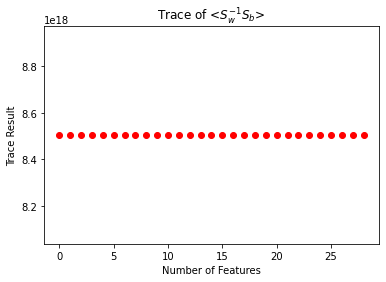

In [20]:
plt.plot(range(len(trace_results)), trace_results, 'or', linewidth = 2)
plt.xlabel('Number of Features')
plt.ylabel('Trace Result')
plt.title('Trace of <$S_w^{-1}S_b$>')
plt.show()